# some things

In [1]:
from ultralytics import YOLO
model = YOLO("models/fracture.pt")  


In [ ]:
model.export(format='engine', dynamic=True)  # export to torchscript

WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5782MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'models/fracture.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 21.8s, saved as 'models/fracture.onnx' (36.1 MB)

TensorRT: starting export with TensorRT 10.8.0.43...
[03/05/2025-10:24:33] [TRT] [I] The logger passed into createInferBuilder differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[03/05/2025-10:24:38] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU -2755, GPU +436, now: CPU 4900, GPU 1005 (MiB)
[03/05/2025-1

'models/fracture.engine'

In [1]:
import os

In [ ]:
!python -c "import tensorrt; print(tensorrt.__path__)"

['/home/juangt/Documents/Study/TFE/orthanc/fracturedetect/venv/lib/python3.11/site-packages/tensorrt']


In [ ]:
os.environ['LD_LIBRARY_PATH'] = '/home/juangt/Downloads/TensorRT-10.8.0.43/lib/'

In [ ]:
!execstack -c 'venv/lib/python3.11/site-packages/tensorrt_libs/libnvinfer_builder_resource.so.10.8.0'

execstack: venv/lib/python3.11/site-packages/tensorrt_libs/libnvinfer_builder_resource.so.10.8.0: section file offsets not monotonically increasing


In [ ]:
!patchelf --clear-execstack venv/lib/python3.11/site-packages/tensorrt_libs/libnvinfer_builder_resource.so.10.8.0

In [2]:
import tensorrt 
print(tensorrt.__version__) 
assert tensorrt.Builder(tensorrt.Logger())

10.8.0.43


In [3]:
import torch
torch.cuda.is_available()

True

# First method

In [12]:
model = YOLO("models/fracture.engine")  

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [4]:
import torch
import torch.nn.functional as F
import numpy as np

def split_image(image_tensor, square_size=256, overlap=51):
    _, h, w = image_tensor.shape
    squares = []
    positions = []

    # calc stride
    stride = square_size - overlap

    # iter with stride
    for i in range(0, h, stride):
        for j in range(0, w, stride):
            # no oob
            y_start = i
            y_end = min(i + square_size, h)
            x_start = j
            x_end = min(j + square_size, w)

            # get square
            square = image_tensor[:, y_start:y_end, x_start:x_end]

            # padding
            pad_h = square_size - (y_end - y_start)
            pad_w = square_size - (x_end - x_start)
            if pad_h > 0 or pad_w > 0:
                square = F.pad(square, (0, pad_w, 0, pad_h))

            squares.append(square)
            positions.append((y_start, x_start))

    return squares, positions

def combine_detections(detections, positions):
    combined_boxes = []
    combined_confidences = []
    combined_labels = []

    for (boxes, confidences, labels), (i, j) in zip(detections, positions):
        boxes[:, [0, 2]] += j
        boxes[:, [1, 3]] += i
        combined_boxes.append(boxes)
        combined_confidences.append(confidences)
        combined_labels.append(labels)

    combined_boxes = np.concatenate(combined_boxes, axis=0)
    combined_confidences = np.concatenate(combined_confidences, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    

    return {
        'boxes': combined_boxes,
        'confidences': combined_confidences,
        'labels': combined_labels
    }

def detect1(image,model,device):
    img = Image.open(image).convert("RGB")  
    im_array = np.array(img)  # Convert to NumPy array
    im_array = np.transpose(im_array, (2, 0, 1))  # HWC -> CHW
    image_tensor = torch.tensor(im_array, dtype=torch.float32)
    image_tensor = image_tensor/image_tensor.max()
    squares, positions = split_image(image_tensor)

    detections = []
    for square in squares:
        square = square.unsqueeze(0)  # Add batch dimension
        # square = square / square.max()  # Normalize tensor

        results = model(square, device=device,imgsz=256,conf=0.2,verbose=False)
        detections.append((
            results[0].boxes.xyxy.cpu().numpy(),
            results[0].boxes.conf.cpu().numpy(),
            results[0].boxes.cls.cpu().numpy()
        ))
    

    combined_results = combine_detections(detections, positions)

    return combined_results

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image

image = "sample-images/IMG0002305.jpg"

# Load image using PIL and convert to tensor
  

# Run detection
device='cpu'
detected = detect1(image, model,device)
print(detected)

# Load image using OpenCV for visualization
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistency

# Get detection results
boxes = detected['boxes']
confidences = detected['confidences']
labels = detected['labels']

# Draw bounding boxes
for i in range(len(boxes)):
    box = boxes[i]
    confidence = confidences[i]
    label = int(labels[i])
    x1, y1, x2, y2 = box.astype(int)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 5)
    text = f"{confidence:.2f}, Label: {label}"
    cv2.putText(img, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), 3)

# Resize for display
height, width, _ = img.shape
img = cv2.resize(img, (width // 2, height // 2))

cv2.imshow("Detected Objects", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


{'boxes': array([[     1016.2,      788.79,      1261.1,      1012.5],
       [     1058.8,      2666.1,      1117.5,      2769.4]], dtype=float32), 'confidences': array([    0.77256,     0.48221], dtype=float32), 'labels': array([0, 0])}


In [ ]:
results = model.predict(image,imgsz=640, visualize=False,device='0')
for result in results:
    result.show()

# Diff approach

In [5]:
import torch
from torchvision.transforms import functional as Fn
import numpy as np
import cv2

class ResizeBetter:
    def __init__(self, min_size):
        self.min_size = min_size

    def __call__(self, image):
        _, h, w = image.shape  # C, H, W
        scale = self.min_size / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)

        image = Fn.resize(image, (new_h, new_w), interpolation=Fn.InterpolationMode.BILINEAR)

        pad_w = (self.min_size - new_w) // 2
        pad_h = (self.min_size - new_h) // 2

        image = Fn.pad(image, (pad_w, pad_h, self.min_size - new_w - pad_w, self.min_size - new_h - pad_h))

        return image

def split_image(image_tensor, square_size=256, overlap=51):
    _, h, w = image_tensor.shape
    squares = []
    positions = []

    # calc stride
    stride = square_size - overlap

    # iter with stride
    for i in range(0, h, stride):
        for j in range(0, w, stride):
            # no oob
            y_start = i
            y_end = min(i + square_size, h)
            x_start = j
            x_end = min(j + square_size, w)

            # get square
            square = image_tensor[:, y_start:y_end, x_start:x_end]

            # padding
            pad_h = square_size - (y_end - y_start)
            pad_w = square_size - (x_end - x_start)
            if pad_h > 0 or pad_w > 0:
                square = F.pad(square, (0, pad_w, 0, pad_h))

            squares.append(square)
            positions.append((y_start, x_start))

    return squares, positions

def combine_detections(detections, positions):
    combined_boxes, combined_confidences, combined_labels = [], [], []
    
    for (boxes, confidences, labels), (i, j) in zip(detections, positions):
        boxes[:, [0, 2]] += j
        boxes[:, [1, 3]] += i
        combined_boxes.append(boxes)
        combined_confidences.append(confidences)
        combined_labels.append(labels)
    
    return {
        'boxes': np.concatenate(combined_boxes, axis=0),
        'confidences': np.concatenate(combined_confidences, axis=0),
        'labels': np.concatenate(combined_labels, axis=0)
    }

def apply_nms(boxes, confidences, labels, iou_thresh=0.5):
    # TODO - find a better option than cv2.dnn.NMSBoxes
    if len(boxes) == 0:
        return np.array([]), np.array([]), np.array([])
    
    idxs = cv2.dnn.NMSBoxes(boxes.tolist(), 
                            confidences.tolist(), 
                            score_threshold=0.1, 
                            nms_threshold=iou_thresh)
    if len(idxs) > 0:
        idxs = idxs.flatten()
    return boxes[idxs], confidences[idxs], labels[idxs]

def detect2(image, model,device):
    # 1. Full Image Detection (Resized to 640)
    img = Image.open(image).convert("RGB")  
    im_array = np.array(img)  # Convert to NumPy array
    im_array = np.transpose(im_array, (2, 0, 1))  # HWC -> CHW
    image_tensor = torch.tensor(im_array, dtype=torch.float32)  
    image_tensor = image_tensor / image_tensor.max()
    full_img_resized = ResizeBetter(640)(image_tensor)
    full_results = model(full_img_resized.unsqueeze(0), device=device, imgsz=640, conf=0.2,verbose=False)
    
    full_boxes = full_results[0].boxes.xyxy.cpu().numpy()
    full_confidences = full_results[0].boxes.conf.cpu().numpy()
    full_labels = full_results[0].boxes.cls.cpu().numpy()
    
    # Scale back to original image size
    _, orig_h, orig_w = image_tensor.shape
    full_boxes[:, [0, 2]] *= (orig_w / 640)
    full_boxes[:, [1, 3]] *= (orig_h / 640)
    
    # 2. Square Image Detection
    
    # patch_results = combine_detections(detections, positions)
    patch_results = detect4(image,detection_model,device)
    
    # 3. combine full and square results
    if patch_results and patch_results['boxes'].size > 0:
        all_boxes = np.concatenate([full_boxes, patch_results['boxes']], axis=0)
        all_confidences = np.concatenate([full_confidences, patch_results['confidences']], axis=0)
        all_labels = np.concatenate([full_labels, patch_results['labels']], axis=0)
    else:
        all_boxes = full_boxes
        all_confidences = full_confidences
        all_labels = full_labels
    
    # 4. nms on combined results
    final_boxes, final_confidences, final_labels = apply_nms(all_boxes, all_confidences, all_labels)
    
    return {
        'boxes': final_boxes,
        'confidences': final_confidences,
        'labels': final_labels
    }


In [11]:
from PIL import Image
class ResizeBetter:
    def __init__(self, min_size):
        self.min_size = min_size

    def __call__(self, image):
        _, h, w = image.shape  # C, H, W
        scale = self.min_size / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)

        image = Fn.resize(image, (new_h, new_w), interpolation=Fn.InterpolationMode.BILINEAR)

        pad_w = (self.min_size - new_w) // 2
        pad_h = (self.min_size - new_h) // 2

        image = Fn.pad(image, (pad_w, pad_h, self.min_size - new_w - pad_w, self.min_size - new_h - pad_h))

        return image
    
def detect3(image, model,device):
    # 1. Full Image Detection (Resized to 640)
    img = Image.open(image).convert("RGB")  
    im_array = np.array(img)  # Convert to NumPy array
    im_array = np.transpose(im_array, (2, 0, 1))  # HWC -> CHW
    image_tensor = torch.tensor(im_array, dtype=torch.float32)  
    image_tensor = image_tensor / image_tensor.max()
    full_img_resized = ResizeBetter(640)(image_tensor)
    full_results = model(full_img_resized.unsqueeze(0), device=device, imgsz=640, conf=0.2,verbose=False)
    full_boxes = full_results[0].boxes.xyxy.cpu().numpy()
    full_confidences = full_results[0].boxes.conf.cpu().numpy()
    full_labels = full_results[0].boxes.cls.cpu().numpy()
    _, orig_h, orig_w = image_tensor.shape
    full_boxes[:, [0, 2]] *= (orig_w / 640)
    full_boxes[:, [1, 3]] *= (orig_h / 640)
    return {
        'boxes': full_boxes,
        'confidences': full_confidences,
        'labels': full_labels
    }
    

In [34]:
import cv2
from PIL import Image

image = "sample-images/IMG0002305.jpg"
device = "cpu"
detected = detect2(image, model, device)
print(detected) 
img = cv2.imread(image)
# img = cv2.resize(img, (2000, 2000))
boxes = detected['boxes']
print(len(boxes))
confidences = detected['confidences']
labels = detected['labels']
for i in range(len(boxes)):
    box = boxes[i]
    confidence = confidences[i]
    label = int(labels[i])
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 5)

    text = f"{confidence:.2f}, Label: {label}"
    cv2.putText(img, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), 3)

width, height, _ = img.shape
img = cv2.resize(img, (width//2, height//2))
cv2.imshow("Detected Objects", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

{'boxes': array([[       1002,      784.78,      1287.7,      1014.7]]), 'confidences': array([    0.82702]), 'labels': array([          0])}
1


# SAHI

In [7]:
from sahi.predict import get_sliced_prediction
from sahi import AutoDetectionModel


def detect4(image,detection_model,device):
    result = get_sliced_prediction(
        image,
        detection_model,
        slice_height=256,
        slice_width=256,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
        verbose=False
    ).object_prediction_list
    boxes = []
    confidences = []
    labels = []
    for obj in result:
        boxes.append(obj.bbox.to_xyxy())
        confidences.append(obj.score.value)
        labels.append(obj.category.id)

    detected = {
        'boxes': np.array(boxes),
        'confidences': np.array(confidences),
        'labels': np.array(labels)
    }
    return detected




In [5]:
import cv2
import torch
import numpy as np
from PIL import Image

image = "sample-images/IMG0002305.jpg"

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov11', 
    model_path='models/fracture.engine', 
    confidence_threshold=0.25,
    device='0'

)

# Run detection
detected = detect4(image,detection_model,device='0')
print(detected)

# Load image using OpenCV for visualization
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistency

# Get detection results
boxes = detected['boxes']
confidences = detected['confidences']
labels = detected['labels']

# Draw bounding boxes
for i in range(len(boxes)):
    box = boxes[i]
    confidence = confidences[i]
    label = int(labels[i])
    x1, y1, x2, y2 = box.astype(int)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 5)
    text = f"{confidence:.2f}, Label: {label}"
    cv2.putText(img, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), 3)

# Resize for display
height, width, _ = img.shape
img = cv2.resize(img, (width // 2, height // 2))

cv2.imshow("Detected Objects", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading models/fracture.engine for TensorRT inference...
[03/05/2025-13:12:50] [TRT] [I] Loaded engine size: 48 MiB
[03/05/2025-13:12:50] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +36, now: CPU 0, GPU 77 (MiB)
{'boxes': array([[       1002,      784.78,      1287.7,      1014.7]]), 'confidences': array([    0.82702]), 'labels': array([0])}


# Comparisons


## Fracture

In [8]:
from ultralytics import YOLO

In [ ]:
import os
import glob
import time
import cv2
import torch
from torchvision.ops import box_iou
from tqdm import tqdm
import torch


def load_validation_data(val_dir):
    image_dir = os.path.join(val_dir, "images")
    label_dir = os.path.join(val_dir, "labels")

    # Get all image paths
    val_images = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) + 
                        glob.glob(os.path.join(image_dir, "*.png")))

    val_labels = {}

    for img_path in val_images:
        # Get corresponding label file
        img_name = os.path.basename(img_path).split(".")[0]
        label_path = os.path.join(label_dir, f"{img_name}.txt")

        if not os.path.exists(label_path):
            val_labels[img_path] = []  # No annotations
            continue

        with open(label_path, "r") as f:
            lines = f.readlines()

        img = cv2.imread(img_path)
        h, w, _ = img.shape  # Get image dimensions

        bboxes = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert YOLO format to absolute pixel values
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            bboxes.append((x1, y1, x2, y2, class_id))

        val_labels[img_path] = bboxes

    return val_images, val_labels



def compute_metrics(detections, ground_truths, iou_threshold=0.3):
    if len(detections) == 0 and len(ground_truths) == 0:
        return 1, 1, 1 # Perfect match when both are empty
    elif len(detections) == 0 or len(ground_truths) == 0:
        return 0, 0, 0 # No detections or no ground truth
    pred_boxes = torch.tensor([d[:4] for d in detections]) # Extract bounding boxes
    pred_scores = torch.tensor([d[4] for d in detections]) # Extract confidence scores
    gt_boxes = torch.tensor([g[:4] for g in ground_truths])
    # Sort detections by confidence score (descending order)
    sorted_indices = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sorted_indices]
    ious = box_iou(pred_boxes, gt_boxes) # IoU matrix
    tp = torch.zeros(len(pred_boxes))
    fp = torch.zeros(len(pred_boxes))
    assigned_gt = torch.zeros(len(gt_boxes)) # Track matched ground truths
    for i, pred_box in enumerate(pred_boxes):
        if ious[i].max() > iou_threshold:
            best_match = torch.argmax(ious[i])
            if assigned_gt[best_match] == 0: # Check if this GT is already assigned
                tp[i] = 1
                assigned_gt[best_match] = 1
            else:
                fp[i] = 1 # Duplicate detection
        else:
            fp[i] = 1 # No match found
        cumulative_tp = torch.cumsum(tp, dim=0)
        cumulative_fp = torch.cumsum(fp, dim=0)
        recalls = cumulative_tp / len(gt_boxes)
        precisions = cumulative_tp / (cumulative_tp + cumulative_fp + 1e-10)
        # Compute AP using area under the PR curve (COCO-style interpolation)
        recalls = torch.cat([torch.tensor([0.0]), recalls, torch.tensor([1.0])])
        precisions = torch.cat([torch.tensor([1.0]), precisions, torch.tensor([0.0])])
        for i in range(precisions.shape[0] - 1, 0, -1):
            precisions[i - 1] = torch.maximum(precisions[i - 1], precisions[i])
            recall_changes = recalls[1:] - recalls[:-1]
            ap = torch.sum(recall_changes * precisions[1:]).item() # Trapezoidal rule
            precision = tp.sum().item() / (tp.sum().item() + fp.sum().item() + 1e-10)
            recall = tp.sum().item() / (len(gt_boxes) + 1e-10)
    return precision, recall, ap




# Main function to validate both detection methods
def validate_model(val_dir, detect1, detect2, detect3, model,device):
    val_images, val_labels = load_validation_data(val_dir)

    results = {
        "detect1": {"precision": [], "recall": [], "mAP": [], "mAP50-95": [], "time": []},
        "detect2": {"precision": [], "recall": [], "mAP": [], "mAP50-95": [], "time": []},
        "detect3": {"precision": [], "recall": [], "mAP": [], "mAP50-95": [], "time": []},
        "detect4": {"precision": [], "recall": [], "mAP": [], "mAP50-95": [], "time": []},
    }

    for img_path in tqdm(val_images, desc="Validating"):
        # img_tensor = preprocess_image(img_path)
        ground_truths = val_labels.get(img_path, [])

        # Run detect1
        start_time = time.time()
        det1 = detect1(img_path, model,device)
        elapsed_time1 = time.time() - start_time

        # Run detect2
        start_time = time.time()
        det2 = detect2(img_path, model,device)
        elapsed_time2 = time.time() - start_time

        # Run detect3
        start_time = time.time()
        det3 = detect3(img_path, model,device)
        elapsed_time3 = time.time() - start_time

        # Run detect4
        start_time = time.time()
        det4 = detect4(img_path,detection_model,device)
        elapsed_time4 = time.time() - start_time

        # Extract detections
        det1_boxes = [[b[0], b[1], b[2], b[3], l] for b, c, l in zip(det1["boxes"], det1["labels"],det1["confidences"])]
        det2_boxes = [[b[0], b[1], b[2], b[3], l] for b, c, l in zip(det2["boxes"], det2["labels"],det2["confidences"])]
        det3_boxes = [[b[0], b[1], b[2], b[3], l] for b, c, l in zip(det3["boxes"], det3["labels"],det3["confidences"])]
        det4_boxes = [[b[0], b[1], b[2], b[3], l] for b, c, l in zip(det4["boxes"], det4["labels"],det4["confidences"])]
        # Compute metrics
        p1, r1, mAP1 = compute_metrics(det1_boxes, ground_truths)
        p2, r2, mAP2 = compute_metrics(det2_boxes, ground_truths)
        p3, r3, mAP3 = compute_metrics(det3_boxes, ground_truths)
        p4, r4, mAP4 = compute_metrics(det4_boxes, ground_truths)

        # Store results
        results["detect1"]["precision"].append(p1)
        results["detect1"]["recall"].append(r1)
        results["detect1"]["mAP"].append(mAP1)
        results["detect1"]["time"].append(elapsed_time1)

        results["detect2"]["precision"].append(p2)
        results["detect2"]["recall"].append(r2)
        results["detect2"]["mAP"].append(mAP2)
        results["detect2"]["time"].append(elapsed_time2)

        results["detect3"]["precision"].append(p3)
        results["detect3"]["recall"].append(r3)
        results["detect3"]["mAP"].append(mAP3)
        results["detect3"]["time"].append(elapsed_time3)

        results["detect4"]["precision"].append(p4)
        results["detect4"]["recall"].append(r4)
        results["detect4"]["mAP"].append(mAP4)
        results["detect4"]["time"].append(elapsed_time4)

    # Compute average metrics
    def avg(lst):
        return sum(lst) / len(lst) if len(lst) > 0 else 0

    print("\n--- Validation Results ---")
    for key in results:
        print(f"{key} - Precision: {avg(results[key]['precision']):.4f}, Recall: {avg(results[key]['recall']):.4f}, mAP: {avg(results[key]['mAP']):.4f}, Time: {avg(results[key]['time']):.4f}s")

In [47]:
import os
import glob
import time
import cv2
import json
import torch
import numpy as np
from tqdm import tqdm
from torchvision.ops import box_iou

def load_validation_data(val_dir):
    image_dir = os.path.join(val_dir, "images")
    label_dir = os.path.join(val_dir, "labels")

    val_images = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) + 
                        glob.glob(os.path.join(image_dir, "*.png")))

    val_labels = {}

    for img_path in val_images:
        img_name = os.path.basename(img_path).split(".")[0]
        label_path = os.path.join(label_dir, f"{img_name}.txt")

        if not os.path.exists(label_path):
            val_labels[img_path] = []
            continue

        with open(label_path, "r") as f:
            lines = f.readlines()

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        bboxes = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            bboxes.append((x1, y1, x2, y2, class_id))

        val_labels[img_path] = bboxes

    return val_images, val_labels

def load_json_predictions(json_path):
    """ Load predictions from JSON file """
    with open(json_path, "r") as f:
        data = json.load(f)

    predictions = {}
    for entry in data:
        img_id = entry["image_id"]
        bbox = entry["bbox"]
        category_id = entry["category_id"]
        score = entry["score"]

        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h

        if img_id not in predictions:
            predictions[img_id] = []
        
        predictions[img_id].append([x1, y1, x2, y2, category_id, score])

    return predictions

def compute_metrics(detections, ground_truths, iou_threshold=0.3):
    if len(detections) == 0 and len(ground_truths) == 0:
        return 1, 1, 1 # Perfect match when both are empty
    elif len(detections) == 0 or len(ground_truths) == 0:
        return 0, 0, 0 # No detections or no ground truth
    pred_boxes = torch.tensor([d[:4] for d in detections]) # Extract bounding boxes
    pred_scores = torch.tensor([d[4] for d in detections]) # Extract confidence scores
    gt_boxes = torch.tensor([g[:4] for g in ground_truths])
    # Sort detections by confidence score (descending order)
    sorted_indices = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sorted_indices]
    ious = box_iou(pred_boxes, gt_boxes) # IoU matrix
    tp = torch.zeros(len(pred_boxes))
    fp = torch.zeros(len(pred_boxes))
    assigned_gt = torch.zeros(len(gt_boxes)) # Track matched ground truths
    for i, pred_box in enumerate(pred_boxes):
        if ious[i].max() > iou_threshold:
            best_match = torch.argmax(ious[i])
            if assigned_gt[best_match] == 0: # Check if this GT is already assigned
                tp[i] = 1
                assigned_gt[best_match] = 1
            else:
                fp[i] = 1 # Duplicate detection
        else:
            fp[i] = 1 # No match found
        cumulative_tp = torch.cumsum(tp, dim=0)
        cumulative_fp = torch.cumsum(fp, dim=0)
        recalls = cumulative_tp / len(gt_boxes)
        precisions = cumulative_tp / (cumulative_tp + cumulative_fp + 1e-10)
        # Compute AP using area under the PR curve (COCO-style interpolation)
        recalls = torch.cat([torch.tensor([0.0]), recalls, torch.tensor([1.0])])
        precisions = torch.cat([torch.tensor([1.0]), precisions, torch.tensor([0.0])])
        for i in range(precisions.shape[0] - 1, 0, -1):
            precisions[i - 1] = torch.maximum(precisions[i - 1], precisions[i])
            recall_changes = recalls[1:] - recalls[:-1]
            ap = torch.sum(recall_changes * precisions[1:]).item() # Trapezoidal rule
            precision = tp.sum().item() / (tp.sum().item() + fp.sum().item() + 1e-10)
            recall = tp.sum().item() / (len(gt_boxes) + 1e-10)
    return precision, recall, ap


def validate_model(val_dir, detect1, detect2, detect3, detect4, model, device, json_path):
    val_images, val_labels = load_validation_data(val_dir)
    json_preds = load_json_predictions(json_path)

    results = {
        # "detect1": {"precision": [], "recall": [], "mAP": [], "time": []},
        # "detect2": {"precision": [], "recall": [], "mAP": [], "time": []},
        "detect3": {"precision": [], "recall": [], "mAP": [], "time": []},
        "detect4": {"precision": [], "recall": [], "mAP": [], "time": []},
        "detect5": {"precision": [], "recall": [], "mAP": [], "time": []},
    }

    for img_path in tqdm(val_images, desc="Validating"):
        img_name = os.path.basename(img_path).split(".")[0]
        ground_truths = val_labels.get(img_path, [])

        # # Run detect1
        # start_time = time.time()
        # det1 = detect1(img_path, model, device)
        # elapsed_time1 = time.time() - start_time

        # # Run detect2
        # start_time = time.time()
        # det2 = detect2(img_path, model, device)
        # elapsed_time2 = time.time() - start_time

        # Run detect3
        start_time = time.time()
        det3 = detect3(img_path, model, device)
        elapsed_time3 = time.time() - start_time

        # Run detect4
        start_time = time.time()
        det4 = detect4(img_path,detection_model,device)
        elapsed_time4 = time.time() - start_time

        # Load predictions from JSON (detect5)
        det5_boxes = json_preds.get(img_name, [])

        # Extract detections
        # det1_boxes = [[b[0], b[1], b[2], b[3], l, c] for b, c, l in zip(det1["boxes"], det1["labels"], det1["confidences"])]
        # det2_boxes = [[b[0], b[1], b[2], b[3], l, c] for b, c, l in zip(det2["boxes"], det2["labels"], det2["confidences"])]
        det3_boxes = [[b[0], b[1], b[2], b[3], l, c] for b, c, l in zip(det3["boxes"], det3["labels"], det3["confidences"])]
        det4_boxes = [[b[0], b[1], b[2], b[3], l, c] for b, c, l in zip(det4["boxes"], det4["labels"], det4["confidences"])]

        # Compute metrics
        # p1, r1, mAP1 = compute_metrics(det1_boxes, ground_truths)
        # p2, r2, mAP2 = compute_metrics(det2_boxes, ground_truths)
        p3, r3, mAP3 = compute_metrics(det3_boxes, ground_truths, iou_threshold=0.5)
        p4, r4, mAP4 = compute_metrics(det4_boxes, ground_truths)
        p5, r5, mAP5 = compute_metrics(det5_boxes, ground_truths, iou_threshold=0.5)

        # Store results
        for i, (p, r, mAP) in enumerate([(p3, r3, mAP3), (p4, r4, mAP4), (p5, r5, mAP5)]):
            results[f"detect{i+3}"]["precision"].append(p)
            results[f"detect{i+3}"]["recall"].append(r)
            results[f"detect{i+3}"]["mAP"].append(mAP)

    def avg(lst):
        return sum(lst) / len(lst) if len(lst) > 0 else 0

    print("\n--- Validation Results ---")
    for key in results:
        print(f"{key} - Precision: {avg(results[key]['precision']):.4f}, Recall: {avg(results[key]['recall']):.4f}, mAP: {avg(results[key]['mAP']):.4f}, Time: {avg(results[key]['time']):.4f}s")

In [ ]:
val_dir = "Datasets/fracatlas_final/validation"
model = YOLO("models/fracture.onnx",task="detect")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov11', 
    model_path='models/fracture.onnx', 
    confidence_threshold=0.25,
    device='cpu'

)
device = 'cpu'
validate_model(val_dir, detect1, detect2, detect3, model,device)

In [55]:

val_dir = "Datasets/fracatlas_final/validation"
model = YOLO("models/yolov8_localization_fractureAtlas.pt",task="detect")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov11', 
    model_path='models/fracture.engine', 
    confidence_threshold=0.2,
    device='0'
)
device = '0'
# validate_model(val_dir, detect1, detect2, detect3, model,device)
validate_model(val_dir, detect1, detect2, detect3, detect4, model, device, 'predictions.json')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading models/fracture.engine for TensorRT inference...
[03/19/2025-10:55:42] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[03/19/2025-10:55:42] [TRT] [I] Loaded engine size: 48 MiB
[03/19/2025-10:55:42] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +36, now: CPU 3, GPU 381 (MiB)


Validating: 100%|██████████| 82/82 [00:05<00:00, 13.81it/s]


--- Validation Results ---
detect3 - Precision: 0.4238, Recall: 0.5183, mAP: 0.5081, Time: 0.0000s
detect4 - Precision: 0.5508, Recall: 0.6890, mAP: 0.6687, Time: 0.0000s
detect5 - Precision: 0.5089, Recall: 0.5854, mAP: 0.5762, Time: 0.0000s


In [ ]:

val_dir = "Datasets/fracatlas_final/validation"
model = YOLO("models/fracture.engine",task="detect")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov11', 
    model_path='models/fracture.engine', 
    confidence_threshold=0.2,
    device='0'
)
device = '0'
# validate_model(val_dir, detect1, detect2, detect3, model,device)
validate_model(val_dir, detect1, detect2, detect3, detect4, model, device, 'predictions.json')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading models/fracture.engine for TensorRT inference...
[03/19/2025-10:34:14] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[03/19/2025-10:34:14] [TRT] [I] Loaded engine size: 48 MiB
[03/19/2025-10:34:14] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +36, now: CPU 11, GPU 1166 (MiB)


Validating:   0%|          | 0/82 [00:00<?, ?it/s]

Loading models/fracture.engine for TensorRT inference...
[03/19/2025-10:34:14] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[03/19/2025-10:34:14] [TRT] [I] Loaded engine size: 48 MiB
[03/19/2025-10:34:14] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +36, now: CPU 12, GPU 1244 (MiB)


Validating: 100%|██████████| 82/82 [00:06<00:00, 13.22it/s]


--- Validation Results ---
detect3 - Precision: 0.3618, Recall: 0.3841, mAP: 0.3689, Time: 0.0000s
detect4 - Precision: 0.5508, Recall: 0.6890, mAP: 0.6687, Time: 0.0000s
detect5 - Precision: 0.5089, Recall: 0.5854, mAP: 0.5762, Time: 0.0000s


In [ ]:
val_dir = "Datasets/fracatlas_final/validation"
model = YOLO("models/fracture.pt",task="detect")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov11', 
    model_path='models/fracture.pt', 
    confidence_threshold=0.25,
    device='cpu'

)
device='cpu'
validate_model(val_dir, detect1, detect2, detect3, model,device)

In [20]:
val_dir = "Datasets/fracatlas_final/validation"
model = YOLO("models/fracture.pt",task="detect")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov11', 
    model_path='models/fracture.pt', 
    confidence_threshold=0.25,
    device='0'

)
device='0'
validate_model(val_dir, detect1, detect2, detect3, model,device)

Validating: 100%|██████████| 82/82 [00:20<00:00,  4.00it/s]


--- Validation Results ---
detect1 - Precision: 0.3527, Recall: 0.5305, mAP: 0.5081, Time: 0.0704s
detect2 - Precision: 0.4939, Recall: 0.5488, mAP: 0.5427, Time: 0.0914s
detect3 - Precision: 0.3557, Recall: 0.3841, mAP: 0.3689, Time: 0.0169s
detect4 - Precision: 0.5102, Recall: 0.5732, mAP: 0.5579, Time: 0.0693s


In [26]:
metrics = model.val(data='Datasets/fracatlas_final/data.yaml',
          imgsz=640,
          conf=0.25,
          device='0',
          single_cls=True,
          save_json=True)

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5782MiB)


val: Scanning /home/juangt/Documents/Study/TFE/orthanc/fracturedetect/Datasets/fracatlas_final/validation/labels.cache... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]


                   all         82         91      0.754      0.538      0.651      0.323
Speed: 2.4ms preprocess, 6.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Saving /home/juangt/Documents/Study/TFE/orthanc/orthanc-mammography/runs/detect/val14/predictions.json...
Results saved to /home/juangt/Documents/Study/TFE/orthanc/orthanc-mammography/runs/detect/val14


## LIDC

In [52]:
metrics = model.val(data='Datasets/LIDC/data.yaml',
          imgsz=640,
          conf=0.25,
          device='0',
          single_cls=True,
          save_json=True)

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5782MiB)


val: Scanning /home/juangt/Documents/Study/TFE/orthanc/fracturedetect/Datasets/LIDC/val/labels... 902 images, 0 backgrounds, 0 corrupt: 100%|██████████| 902/902 [00:00<00:00, 1532.41it/s]


val: New cache created: /home/juangt/Documents/Study/TFE/orthanc/fracturedetect/Datasets/LIDC/val/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]


                   all        902        902      0.863      0.745       0.82      0.518
Speed: 0.5ms preprocess, 7.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /home/juangt/Documents/Study/TFE/orthanc/orthanc-mammography/runs/detect/val16/predictions.json...
Results saved to /home/juangt/Documents/Study/TFE/orthanc/orthanc-mammography/runs/detect/val16


In [53]:
val_dir = "Datasets/LIDC/val"
model = YOLO("models/lcancer.engine",task="detect")
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov11', 
    model_path='models/lcancer.engine', 
    confidence_threshold=0.25,
    device='0'

)
device = '0'
# validate_model(val_dir, detect1, detect2, detect3, model,device)
validate_model(val_dir, detect1, detect2, detect3, detect4, model, device, 'predictions_lcancer.json')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading models/lcancer.engine for TensorRT inference...
[03/19/2025-10:40:46] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[03/19/2025-10:40:46] [TRT] [I] Loaded engine size: 45 MiB
[03/19/2025-10:40:46] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +36, now: CPU 2, GPU 229 (MiB)


Validating:   0%|          | 0/902 [00:00<?, ?it/s]

Loading models/lcancer.engine for TensorRT inference...
[03/19/2025-10:40:48] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[03/19/2025-10:40:48] [TRT] [I] Loaded engine size: 45 MiB
[03/19/2025-10:40:48] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +36, now: CPU 3, GPU 303 (MiB)


Validating: 100%|██████████| 902/902 [01:59<00:00,  7.52it/s]


--- Validation Results ---
detect3 - Precision: 0.7045, Recall: 0.8082, mAP: 0.7930, Time: 0.0000s
detect4 - Precision: 0.6078, Recall: 0.8426, mAP: 0.8116, Time: 0.0000s
detect5 - Precision: 0.7267, Recall: 0.7960, mAP: 0.7860, Time: 0.0000s


# Graphs

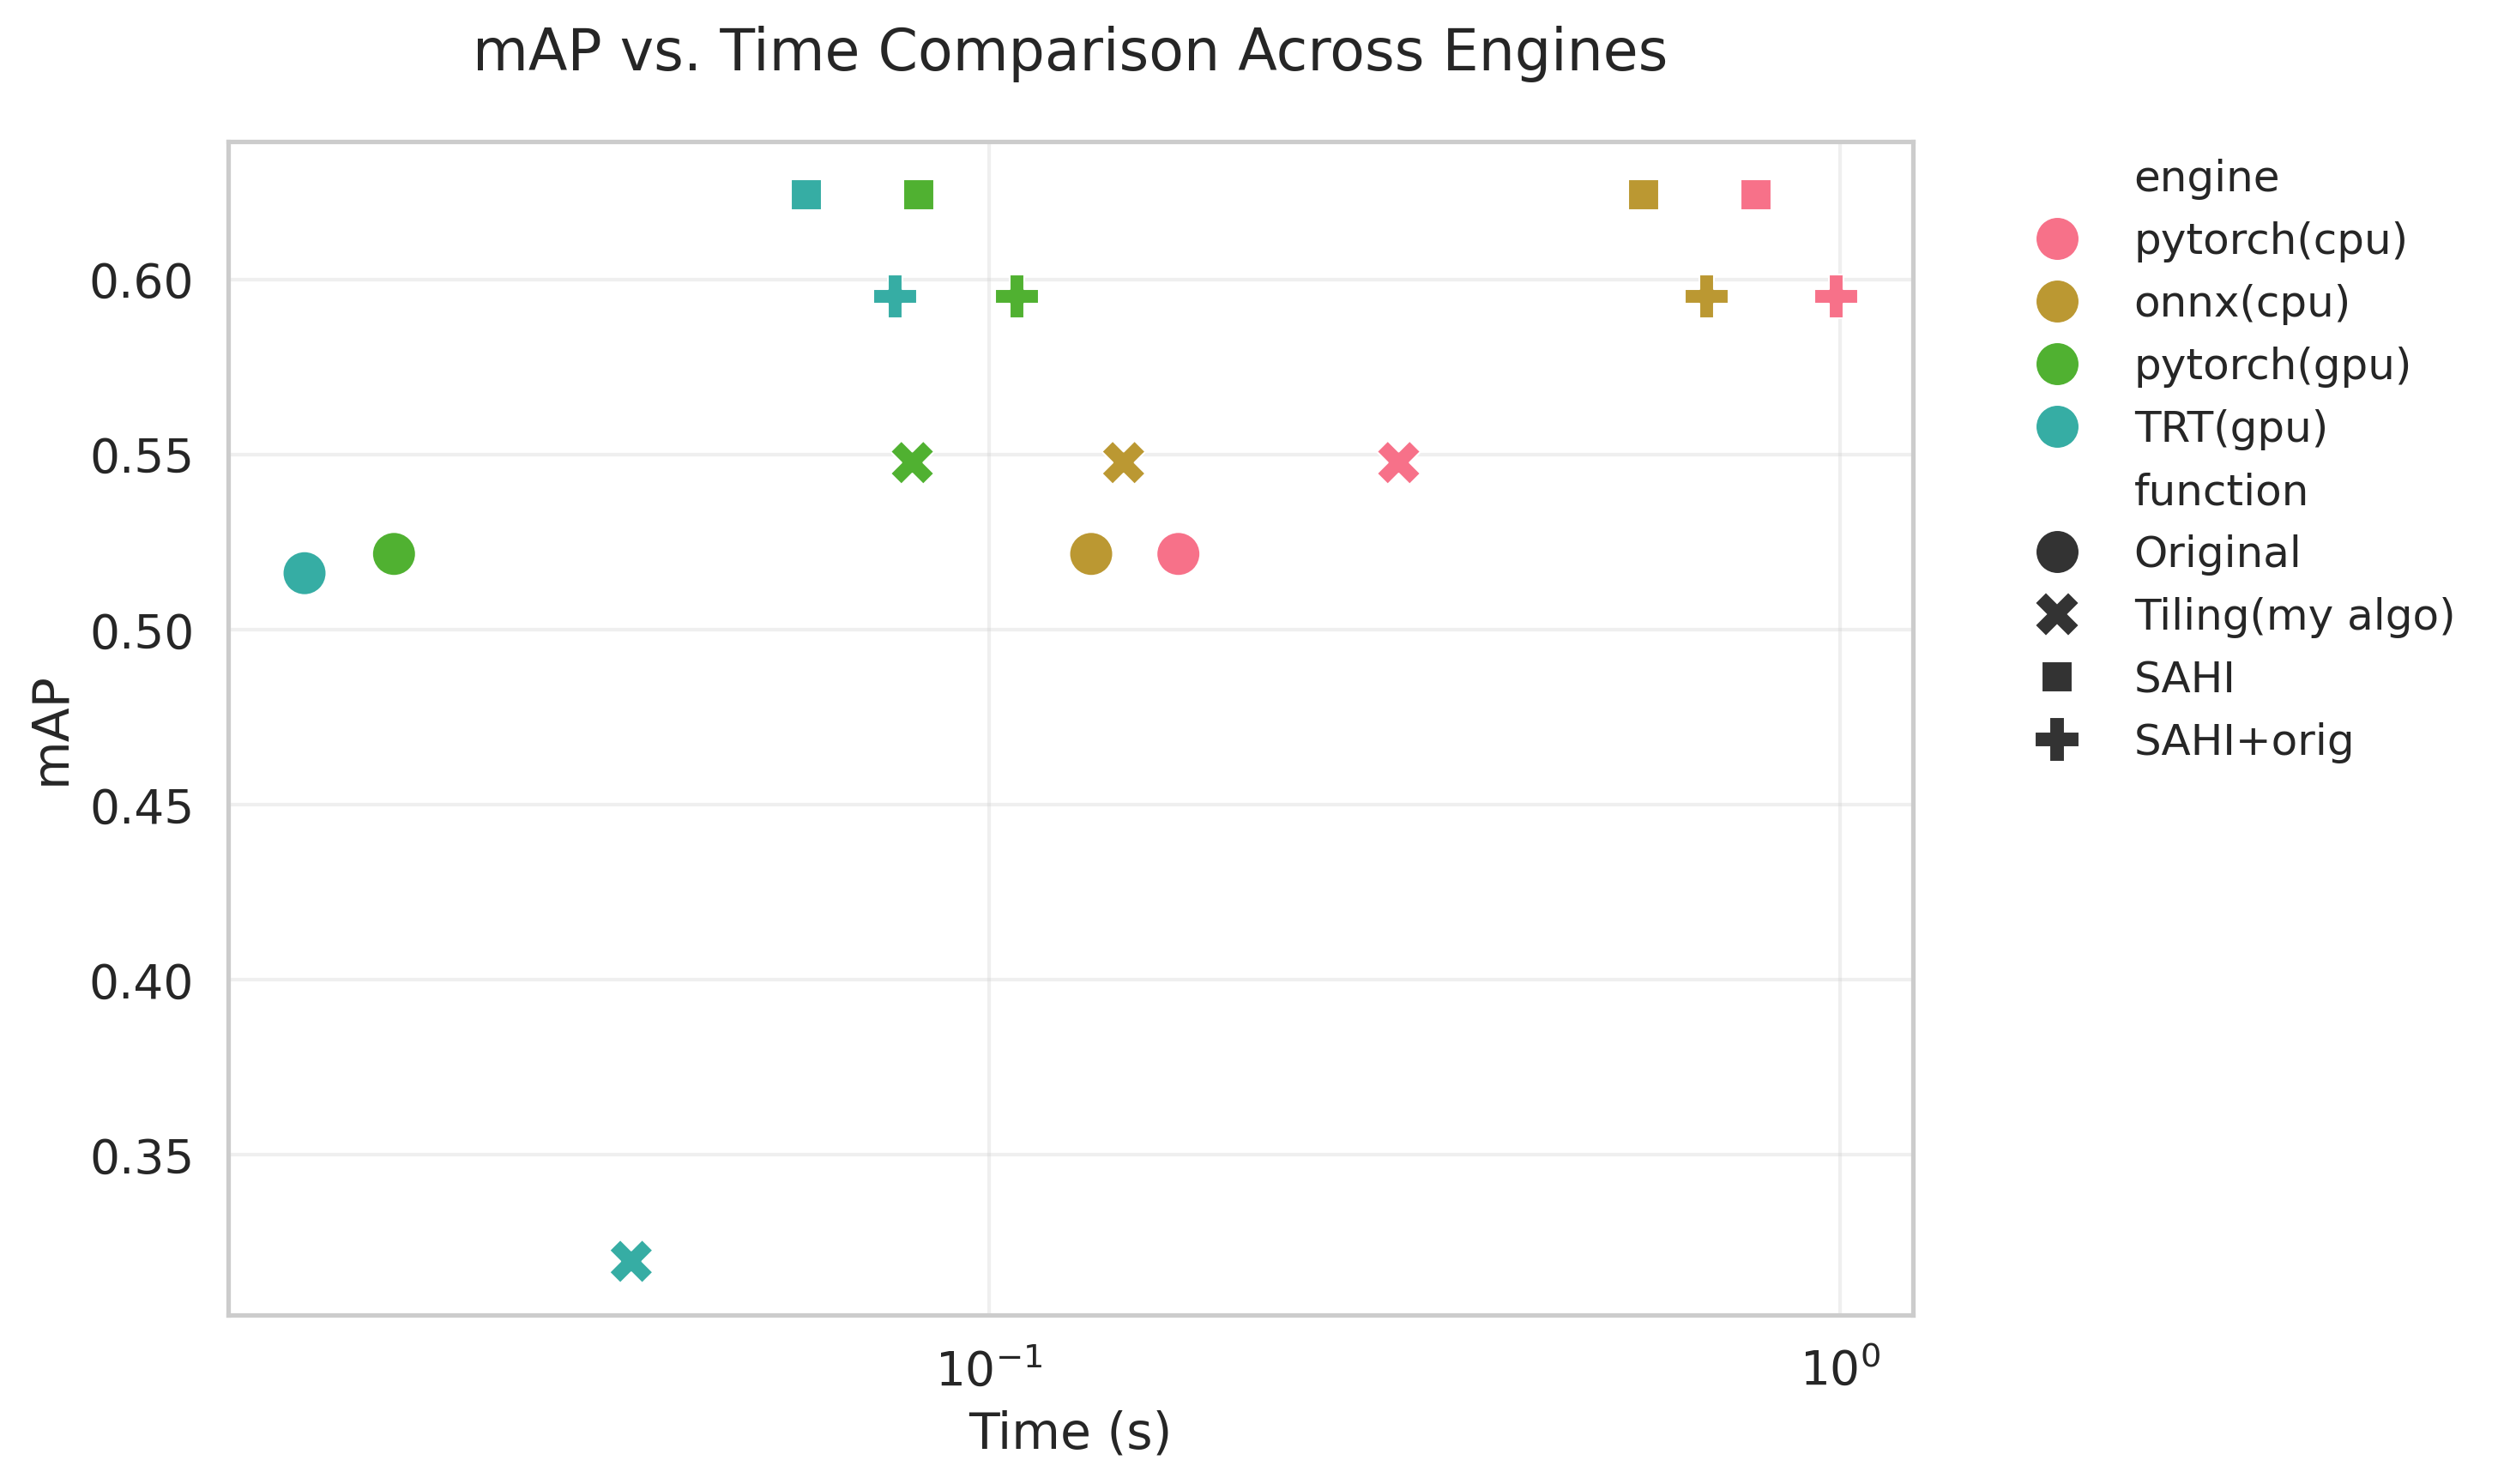

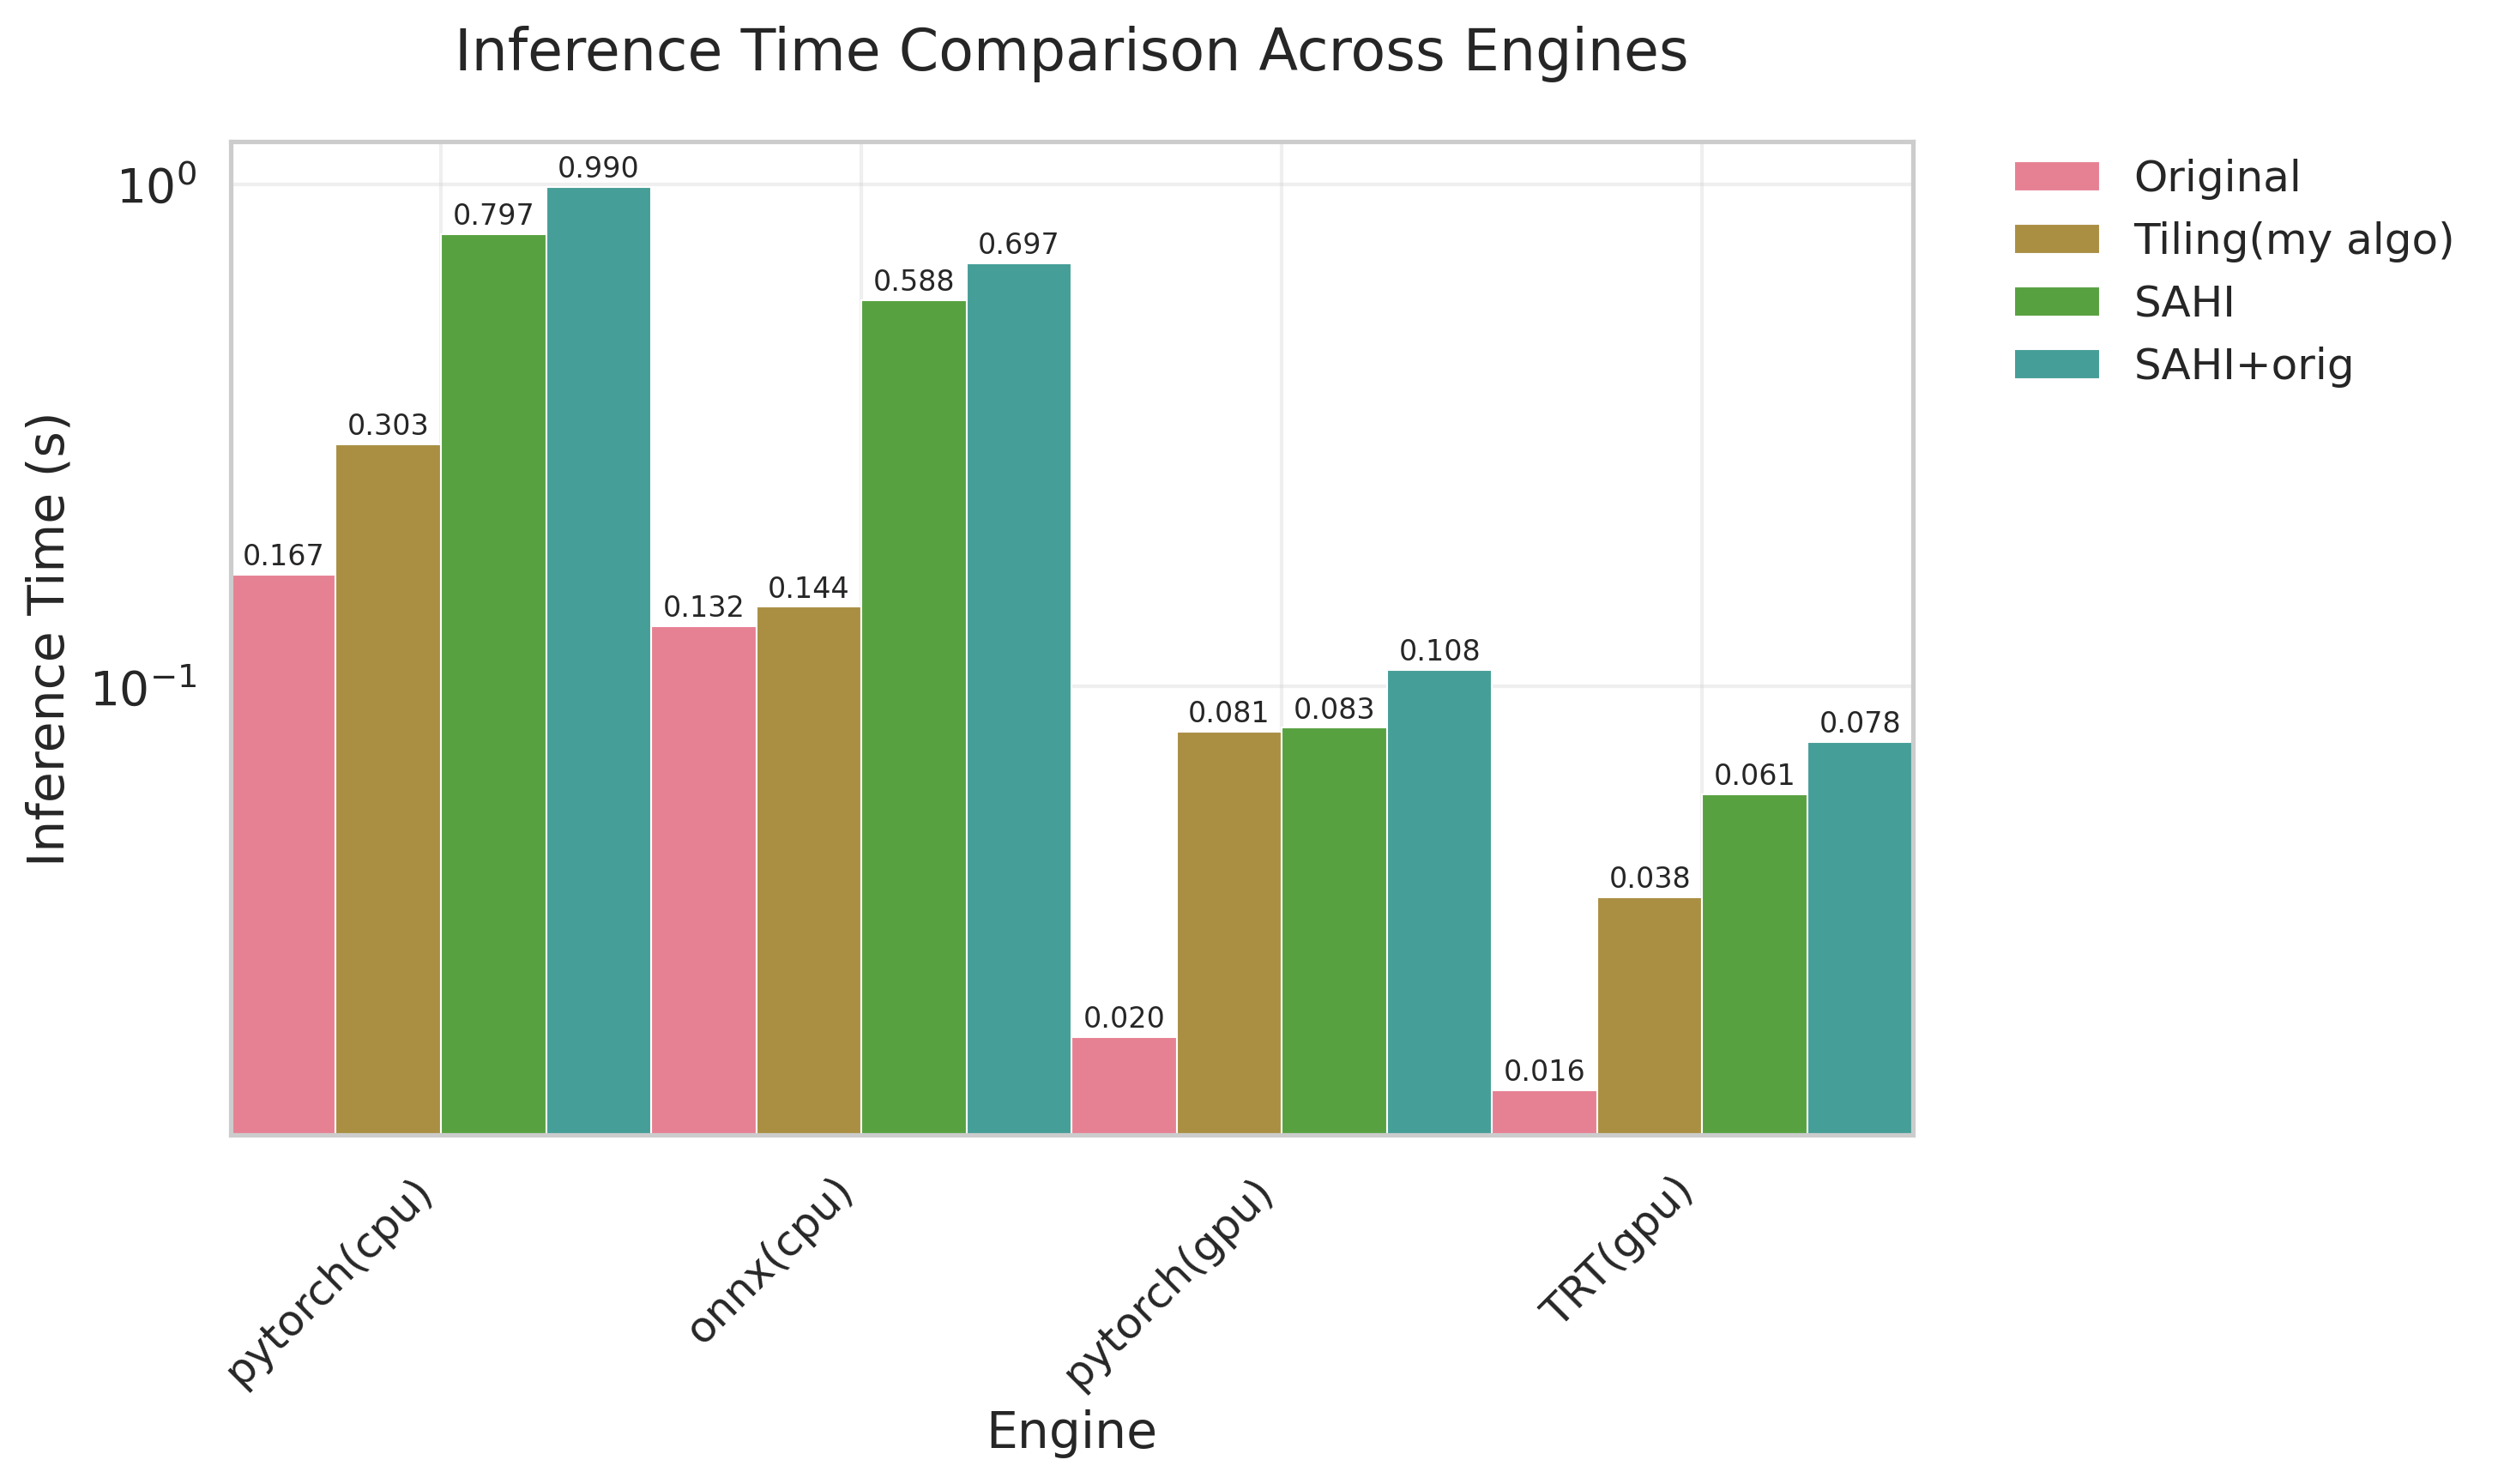

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('metrics.csv')

df[['framework', 'hardware']] = df['engine'].str.split('(', expand=True)
df['hardware'] = df['hardware'].str.rstrip(')')

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_palette("husl")  

plt.rcParams['figure.dpi'] = 300

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x="time(s)", y="mAP", hue="engine", style="function", s=150, edgecolor='w', linewidth=0.5)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("mAP", fontsize=14)
plt.title("mAP vs. Time Comparison Across Engines", fontsize=16, pad=20)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

plt.figure(figsize=(10, 6))
bar = sns.barplot(data=df, x="engine", y="time(s)", 
                  hue="function", edgecolor='w', linewidth=0.5, 
                  width=1)  

# Add value annotations on top of each bar
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=8)

plt.xlabel("Engine", fontsize=14)
plt.ylabel("Inference Time (s)", fontsize=14)
plt.yscale('log')
plt.title("Inference Time Comparison Across Engines", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()